In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry
import json
from utils import *
import math
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from roboflow import Roboflow
import supervision as sv
import cv2

In [2]:
from helper_code.color_detection import alter_image, get_color_masks
from helper_code.full_extraction_pipeline import do_analysis, get_points_new, is_valid_color
from helper_code.legend_extraction import get_legend_extraction

In [3]:
sam = sam_model_registry["default"](checkpoint="../../../Downloads/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

In [4]:
rf = Roboflow(ROBOFLOW_API_KEY)
project = rf.workspace().project("legend_classified")
model = project.version(3).model

loading Roboflow workspace...
loading Roboflow project...


In [5]:
from PIL import Image, ImageEnhance

def alter_image(image_name, filter_type, factor):
    image = Image.open(image_name)
    image = image.convert('RGB')
    if filter_type == "Contrast":
        filter = ImageEnhance.Contrast(image)
        image = filter.enhance(factor)
    elif filter_type == "Brightness":
        filter = ImageEnhance.Brightness(image)
        image = filter.enhance(factor)
    elif filter_type == "Sharpness":
        filter = ImageEnhance.Sharpness(image)
        image = filter.enhance(factor)
    return image

def do_complete_analysis(wBox, hBox, metadata, image_name, boundingBox, legend = None, image_alter = None, factor = 1):

    x_axis = metadata["x-axis"]["range"]
    y_axis = metadata["y-axis"]["range"]
    x_axis_title = metadata["x-axis"]["title"]
    y_axis_title = metadata["y-axis"]["title"]

    axis_labels = []
    rgb_colors = []
    coordinates = []
    for label, color in metadata["types"]:
        axis_labels.append(label)
        rgb_colors.append(color)
    
    image = None
    if image_alter:
        image = alter_image(image_name, image_alter, factor)
    else:
        image = alter_image(image_name, "")
    plt.figure(figsize=(10,10))
    plt.imshow(image)

    
    color_masks, width, height, memo = get_color_masks(image, rgb_colors)

    print("This image has the following colors", memo)

    for color in rgb_colors:
        coordinates.append(get_points_new(color_masks, width, height, boundingBox, color, wBox, hBox, x_axis, y_axis, legend))

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_axis, y_axis, memo

def get_reconstructed_plot(image_num, sam_predictor, yolo_model, image_alter, factor):
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    
    image_name, boundingBox = do_analysis(image_num, sam_predictor)
    legend = get_legend_extraction(image_name, yolo_model)
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, legend, image_alter, factor)

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo

In [35]:
image_num = 5

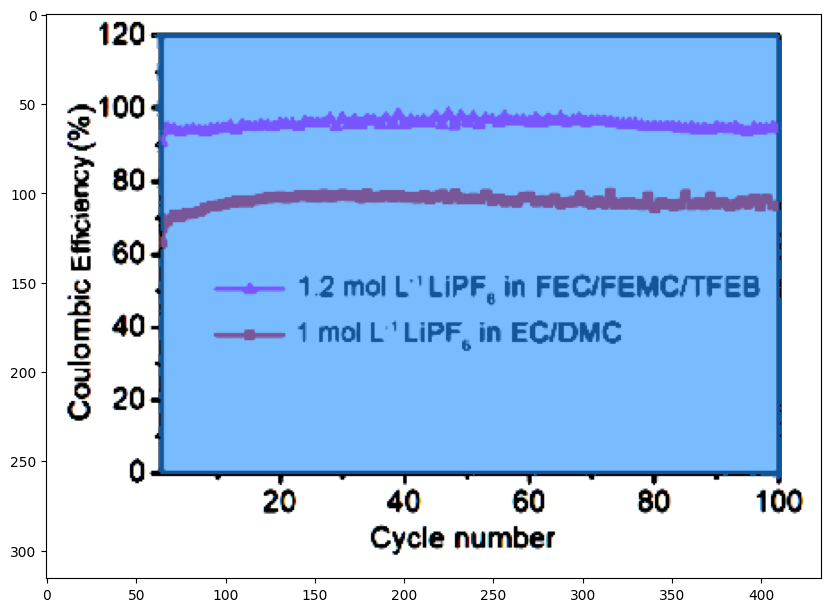

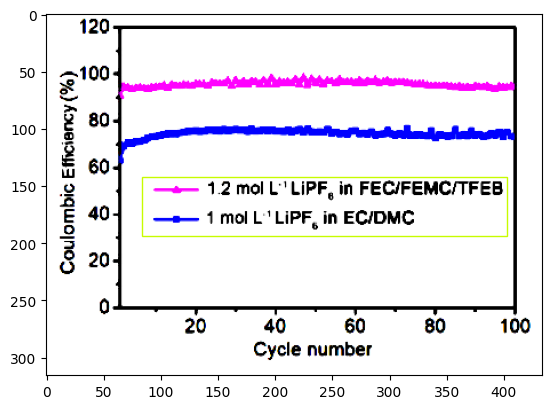

This image has the following colors {'white': 121791, 'orange': 98, 'black': 8617, 'blue': 3310, 'yellow': 98, 'grey': 399, 'red': 76, 'purple': 74, 'green': 17, 'pink': 2657, 'gray': 7}


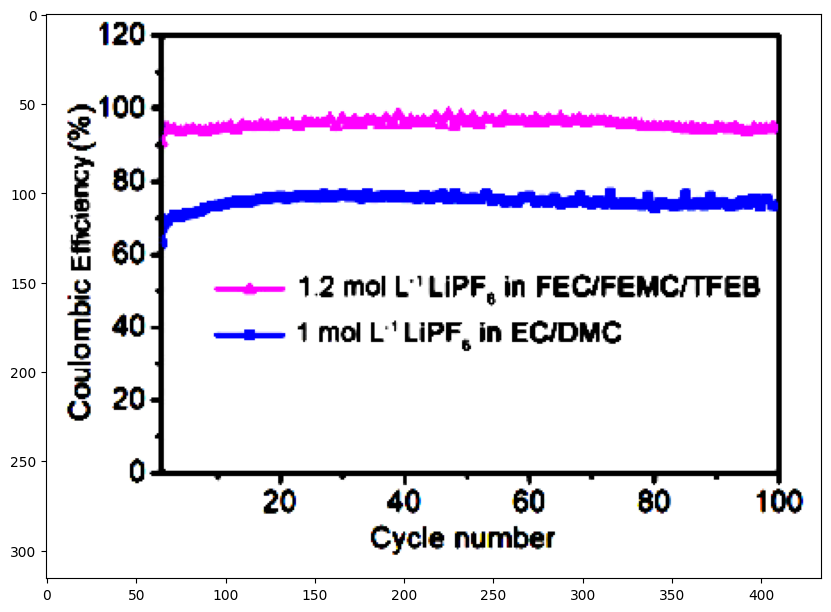

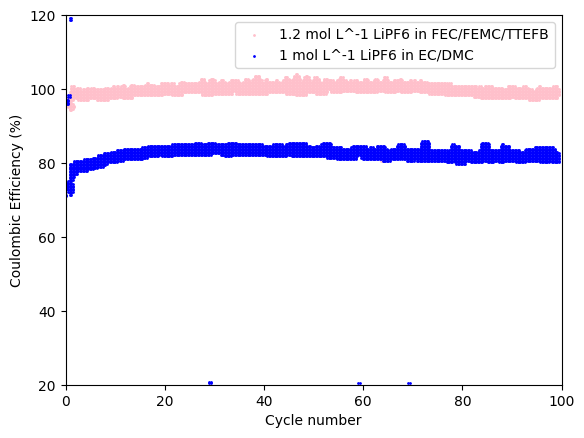

In [36]:
import csv
coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = get_reconstructed_plot(image_num, predictor, model, "Contrast", 2)

plt.figure()
data_for_csv = []
for index, value in enumerate(coordinates):
    x = []
    y = []

    for i in range(len(value)):
        x.append(value[i]["middle"][0])
        y.append(value[i]["middle"][1])
    
    for i, x_i in enumerate(x):
            data_for_csv.append([x_i, y[i], axis_labels[index]])

    color_normalized = rgb_colors[index]

    if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

plt.xlim(x_range[0], x_range[1])
plt.ylim(y_range[0], y_range[1])
plt.xlabel(x_axis_title)
plt.ylabel(y_axis_title)
plt.legend()
plt.show()

# Write to CSV
with open(str(image_num) + ".csv", 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([x_axis_title, y_axis_title, "Type"])  # Header
    writer.writerows(data_for_csv)

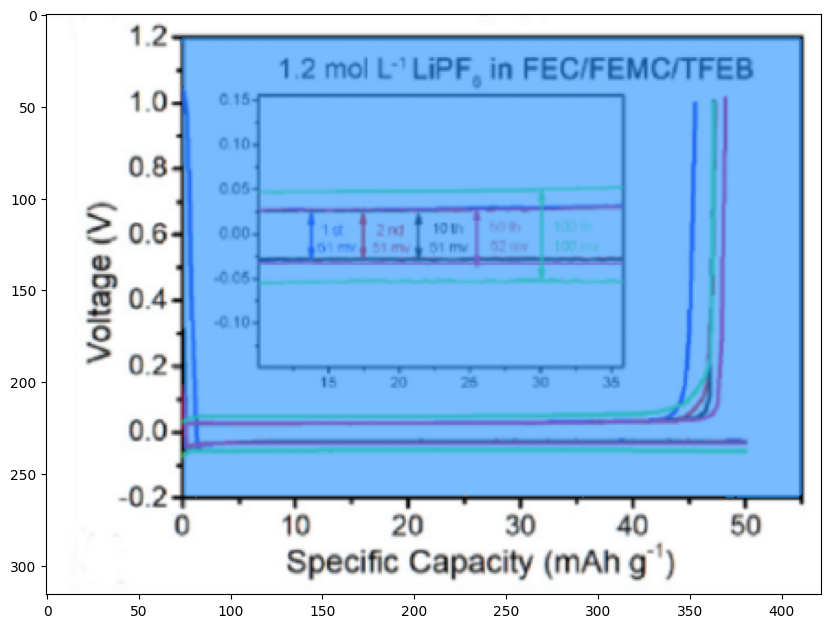

This image has the following colors {'grey': 116638, 'blue': 8802, 'black': 2476, 'red': 188, 'orange': 697, 'green': 2442, 'purple': 2108, 'gray': 1}


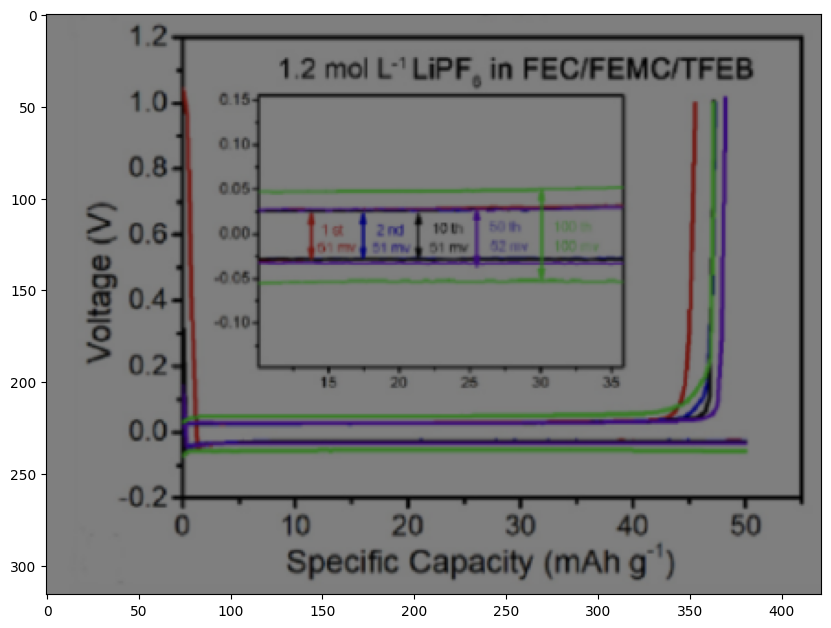

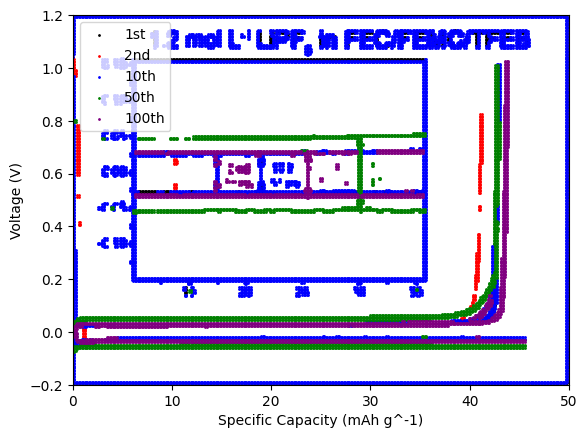

In [26]:
coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = get_reconstructed_plot(image_num, predictor, model, "Brightness", 0.5)

plt.figure()
for index, value in enumerate(coordinates):
    x = []
    y = []

    for i in range(len(value)):
        x.append(value[i]["middle"][0])
        y.append(value[i]["middle"][1])

    color_normalized = rgb_colors[index]

    if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

plt.xlim(x_range[0], x_range[1])
plt.ylim(y_range[0], y_range[1])
plt.xlabel(x_axis_title)
plt.ylabel(y_axis_title)
plt.legend()
plt.show()

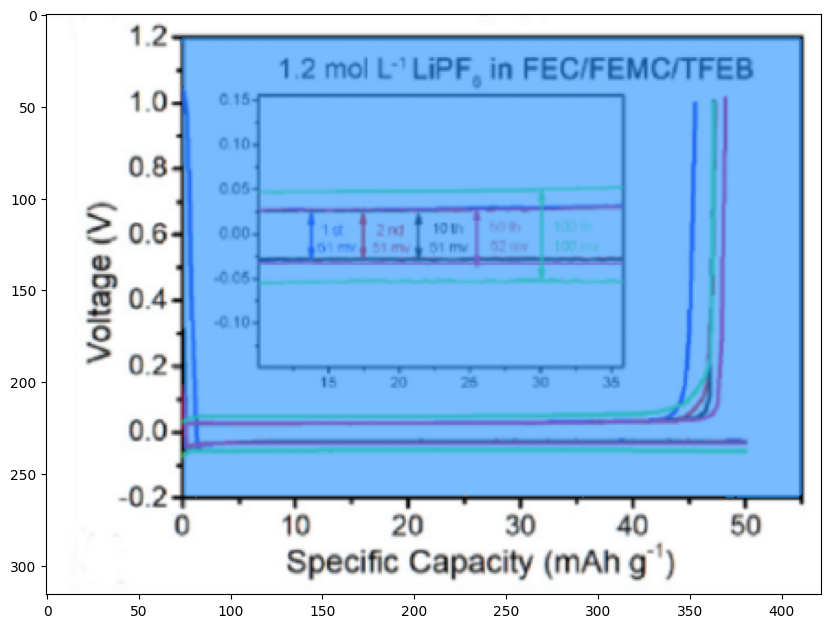

This image has the following colors {'white': 108996, 'grey': 12657, 'blue': 2673, 'gray': 314, 'black': 111, 'pink': 1866, 'orange': 595, 'red': 27, 'purple': 3054, 'green': 2886, 'yellow': 173}


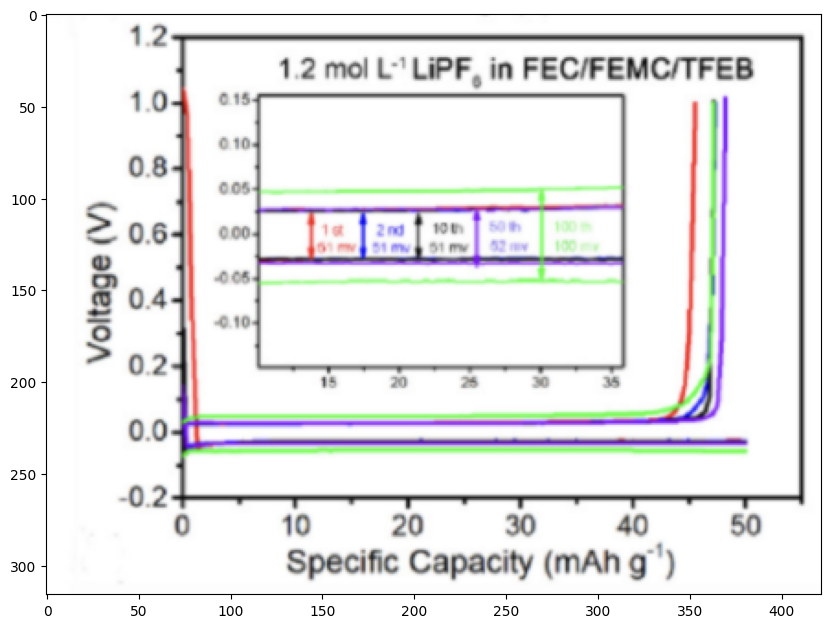

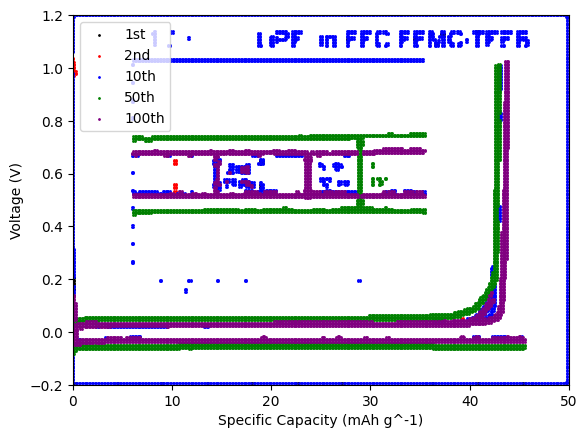

In [27]:
coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = get_reconstructed_plot(image_num, predictor, model, "Sharpness", 0.5)

plt.figure()
for index, value in enumerate(coordinates):
    x = []
    y = []

    for i in range(len(value)):
        x.append(value[i]["middle"][0])
        y.append(value[i]["middle"][1])

    color_normalized = rgb_colors[index]

    if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

plt.xlim(x_range[0], x_range[1])
plt.ylim(y_range[0], y_range[1])
plt.xlabel(x_axis_title)
plt.ylabel(y_axis_title)
plt.legend()
plt.show()

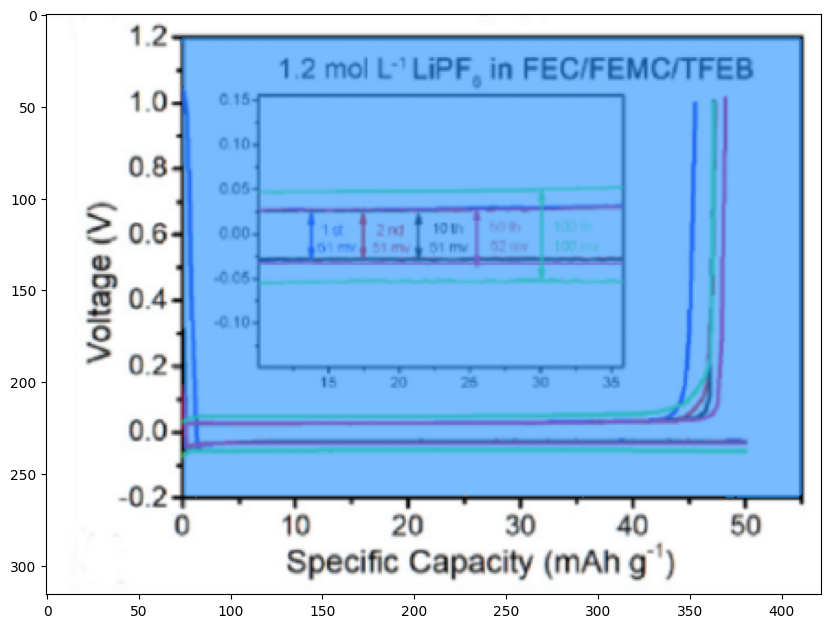

This image has the following colors {'white': 110572, 'grey': 11039, 'blue': 2291, 'gray': 333, 'pink': 1137, 'black': 1166, 'orange': 592, 'red': 153, 'green': 2870, 'purple': 2974, 'yellow': 225}


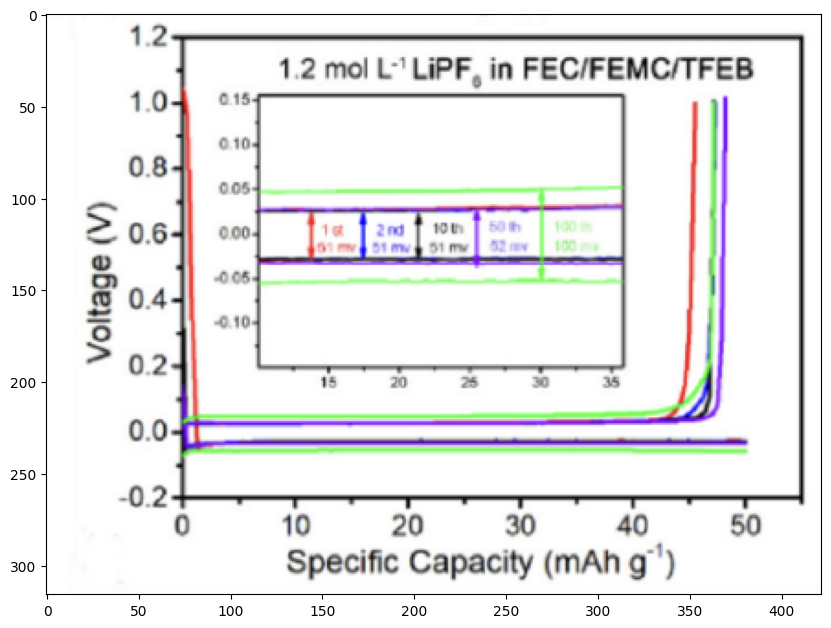

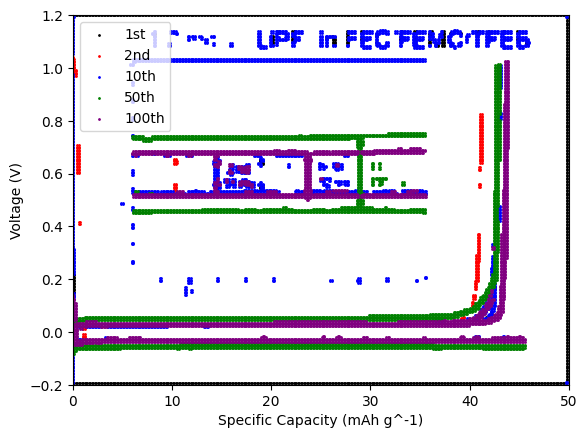

In [19]:
coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = get_reconstructed_plot(image_num, predictor, model, None)

plt.figure()
for index, value in enumerate(coordinates):
    x = []
    y = []

    for i in range(len(value)):
        x.append(value[i]["middle"][0])
        y.append(value[i]["middle"][1])

    color_normalized = rgb_colors[index]

    if (is_valid_color(color_normalized)): plt.scatter(x, y, label=axis_labels[index], color=color_normalized, s=1)

plt.xlim(x_range[0], x_range[1])
plt.ylim(y_range[0], y_range[1])
plt.xlabel(x_axis_title)
plt.ylabel(y_axis_title)
plt.legend()
plt.show()

In [ ]:
def get_reconstructed_plot(image_num, sam_predictor, yolo_model, image_alter, factor):
    prompt = {}
    with open('../plot_json/'+str(image_num)+'.json', 'r') as file:
        prompt = json.load(file)
    
    image_name, boundingBox = do_analysis(image_num, sam_predictor)
    # legend = get_legend_extraction(image_name, yolo_model)
    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = do_complete_analysis(1, 1, prompt, image_name, boundingBox, None, image_alter, factor)

    return coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo

for image_num in range(1, 29):

    coordinates, x_axis_title, y_axis_title, axis_labels, rgb_colors, x_range, y_range, memo = get_reconstructed_plot(image_num, predictor, model, "Contrast", 2)

    data_for_csv = []
    for index, value in enumerate(coordinates):
        x = []
        y = []

        for i in range(len(value)):
            x.append(value[i]["middle"][0])
            y.append(value[i]["middle"][1])
        
        for i, x_i in enumerate(x):
            data_for_csv.append([x_i, y[i], axis_labels[index]])

    # Write to CSV
    with open("../chunwei_data/"+str(image_num) + ".csv", 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([x_axis_title, y_axis_title, "Type"])  # Header
        writer.writerows(data_for_csv)